# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [1]:
GROUP_NO = 123 # group number
GROUP_MEMBERS = {
    123456: "firstname lastname", # mat. no. : name,
    234567: "firstname lastname",
    345678: "firstname lastname",
}

---

In [2]:
# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer();

# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (8 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [3]:
swift_df = pd.read_csv("datasets/q4_taylor_swift.csv")
display(swift_df)

,album,lyric
0,Taylor Swift,He said the way my blue eyes shined
1,Taylor Swift,Put those Georgia stars to shame that night
2,Taylor Swift,"I said, ""That's a lie"""
3,Taylor Swift,Just a boy in a Chevy truck
4,Taylor Swift,That had a tendency of gettin' stuck
...,...,...
8324,evermore (deluxe version),"You know, you know, you know, you know"
8325,evermore (deluxe version),When it's time to go
8326,evermore (deluxe version),So then you go
8327,evermore (deluxe version),Then you go


ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [4]:

swift_df_columns = swift_df.columns
swift_df[swift_df_columns] = (swift_df[swift_df_columns]
         .map(lambda x: unicodedata.normalize('NFKD', x)).map(lambda x: x.replace("(","").replace(")","")))
display(swift_df)

,album,lyric
0,Taylor Swift,He said the way my blue eyes shined
1,Taylor Swift,Put those Georgia stars to shame that night
2,Taylor Swift,"I said, ""That's a lie"""
3,Taylor Swift,Just a boy in a Chevy truck
4,Taylor Swift,That had a tendency of gettin' stuck
...,...,...
8324,evermore deluxe version,"You know, you know, you know, you know"
8325,evermore deluxe version,When it's time to go
8326,evermore deluxe version,So then you go
8327,evermore deluxe version,Then you go


### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [5]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """
    return input_df.groupby(by='album').count().squeeze()

In [6]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})

,album,lyric count
0,1989 Deluxe,1003
1,Fearless Taylor’s Version,1170
2,Lover,932
3,Red Deluxe Edition,1064
4,Speak Now Deluxe,935
5,Taylor Swift,609
6,evermore deluxe version,909
7,folklore deluxe version,722
8,reputation,985


### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [7]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    input_series.plot.bar(x=input_series.index, y=input_series.values)

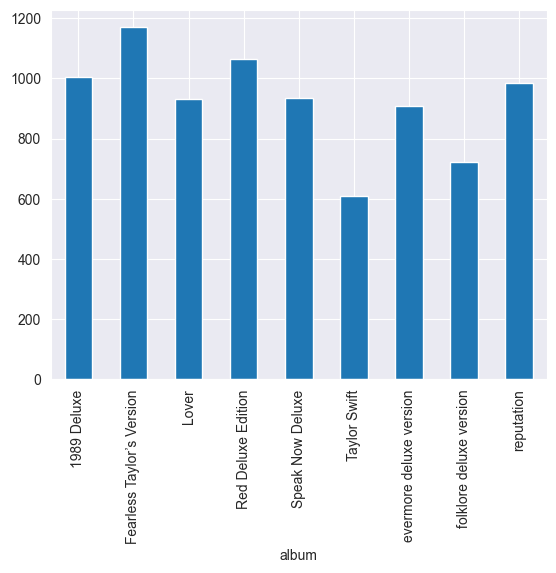

In [8]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer: the number of lyrics of the most albums are around 1000, but some albums like Taylor Swift, that only has half size of lines comparing to most frequent albumn, has relative small number of lyrics. The data is not enough balanced for album classification.

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

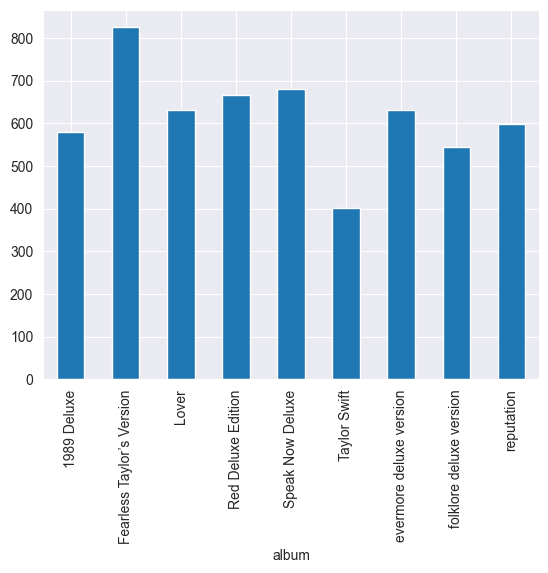

In [9]:
# Dropping all duplicates of a lyric on an album
swift_df_proc = swift_df.drop_duplicates();
count_per_album = count_lyrics_per_album(swift_df_proc)
plot_lyric_count(count_per_album)

ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

__Student Answer:__ As we can see the lists above, some lines gets deleted after removing the duplicates. So some lyrics do occur in several albums.

In [10]:
count_per_album = count_lyrics_per_album(swift_df_proc)
display(count_per_album)
swift_df_proc = swift_df_proc.drop_duplicates(subset=['lyric'], keep=False)
count_per_album = count_lyrics_per_album(swift_df_proc)
display(count_per_album)


album
1989 Deluxe                  580
Fearless Taylor’s Version    825
Lover                        632
Red Deluxe Edition           665
Speak Now Deluxe             681
Taylor Swift                 402
evermore deluxe version      632
folklore deluxe version      544
reputation                   598
Name: lyric, dtype: int64

album
1989 Deluxe                  574
Fearless Taylor’s Version    818
Lover                        629
Red Deluxe Edition           660
Speak Now Deluxe             678
Taylor Swift                 399
evermore deluxe version      629
folklore deluxe version      542
reputation                   597
Name: lyric, dtype: int64

album
1989 Deluxe                  574
Fearless Taylor’s Version    818
Lover                        629
Red Deluxe Edition           660
Speak Now Deluxe             678
Taylor Swift                 399
evermore deluxe version      629
folklore deluxe version      542
reputation                   597
Name: lyric, dtype: int64

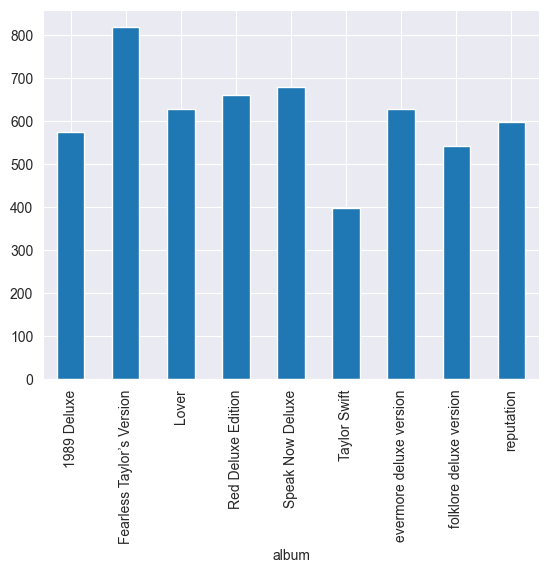

In [11]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [12]:
# Creating the corpus
corpus = swift_df_proc['lyric'].astype(str).values.tolist()

### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

_Note: To keep the complexity low, we do not expect you to use POS tagging before lemmatizing. You can apply lemmatization only for the nouns. This is covered by using a lemmatizer without further arguments._

In [13]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    str_list = reg_tokenizer.tokenize(text)
    str_list = [ x for x in str_list if x.lower() not in stopword_list ]
    return_str = ""
    for temp_str in str_list:
        return_str += wordnet_lemmatizer.lemmatize(temp_str).lower()+' '
        
    # remove the empty space at the end of the string
    return_str = return_str[:-1]
    return return_str
    

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [14]:
# Corpus preprocessing
corpus_proc = list(map(preprocessor_func,corpus))

### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [15]:
df_train, df_test, y_train, y_test = train_test_split(
    swift_df_proc['lyric'],swift_df_proc['album'], test_size=0.2, 
)

### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [16]:
corpus_train = df_train.astype(str).values.tolist()
corpus_test = df_test.astype(str).values.tolist()

## Set of Words (6.5 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [168]:
# Creating a set of words using the propressor function and the corpus
corpus_temp = list(map(preprocessor_func,corpus))
set_words = []
for x in corpus_temp:
    list(map(set_words.append,x.split(" ")))
# to lowercase
set_words = [x.lower() for x in set_words]
# remove all duplicates
set_words = list( dict.fromkeys(set_words) )
display(set_words)

['said way blue eye shined',
 'put georgia star shame night',
 'said lie',
 'boy chevy truck',
 'tendency gettin stuck',
 'back road night',
 'right beside summer long',
 'time woke find summer gone',
 'think tim mcgraw',
 'hope think favorite song',
 'one danced night long',
 'moon like spotlight lake',
 'think happiness',
 'hope think little black dress',
 'think head chest',
 'old faded blue jean',
 'think tim mcgraw',
 'hope think',
 'september saw month tear',
 'thankin god',
 'see like',
 'box beneath bed',
 'letter never read',
 'three summer back',
 'hard find little bittersweet',
 'lookin back nice believe',
 'back first time since',
 'standin street',
 'letter left doorstep',
 'first thing read',
 'think tim mcgraw',
 'someday turn radio',
 'hope take back place',
 'oh think',
 'mmmm',
 'state obvious get perfect fantasy',
 'realize love could ever love',
 'go tell friend obsessive crazy',
 'fine tell mine gay',
 'way',
 'hate stupid old pickup truck',
 'never let drive',
 'r

['said',
 'way',
 'blue',
 'eye',
 'shined',
 'put',
 'georgia',
 'star',
 'shame',
 'night',
 'lie',
 'boy',
 'chevy',
 'truck',
 'tendency',
 'gettin',
 'stuck',
 'back',
 'road',
 'right',
 'beside',
 'summer',
 'long',
 'time',
 'woke',
 'find',
 'gone',
 'think',
 'tim',
 'mcgraw',
 'hope',
 'favorite',
 'song',
 'one',
 'danced',
 'moon',
 'like',
 'spotlight',
 'lake',
 'happiness',
 'little',
 'black',
 'dress',
 'head',
 'chest',
 'old',
 'faded',
 'jean',
 'september',
 'saw',
 'month',
 'tear',
 'thankin',
 'god',
 'see',
 'box',
 'beneath',
 'bed',
 'letter',
 'never',
 'read',
 'three',
 'hard',
 'bittersweet',
 'lookin',
 'nice',
 'believe',
 'first',
 'since',
 'standin',
 'street',
 'left',
 'doorstep',
 'thing',
 'someday',
 'turn',
 'radio',
 'take',
 'place',
 'oh',
 'mmmm',
 'state',
 'obvious',
 'get',
 'perfect',
 'fantasy',
 'realize',
 'love',
 'could',
 'ever',
 'go',
 'tell',
 'friend',
 'obsessive',
 'crazy',
 'fine',
 'mine',
 'gay',
 'hate',
 'stupid',
 'pi

### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [18]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    prepro_lyric = preprocessor_func(swift_df.lyric[index]).split(" ")
    # to lowercase
    prepro_lyric = [xx.lower() for xx in prepro_lyric]
    return swift_df.lyric[index], prepro_lyric, [ prepro_lyric.count(word) for word in set_words ]

In [19]:
index = 1000

In [20]:
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      You had me crawling for you, honey
Preprocessed line:  ['crawling', 'honey']
SoW encoding:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

__Student Answer:__ The value in set is the frequency of the corresponding word in the lyric.

### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [21]:
# Creating the set of words encoding
corpus_train_proc_temp = list(map(preprocessor_func,corpus_train))
# set_words_train = [apply_sow_to_lyric_by_index(lyric_index)[2] for lyric_index in df_train.index]
set_words_train = []
for corpus_train_line in corpus_train:
    prepro_lyric = preprocessor_func(corpus_train_line).split(" ")
    # to lowercase
    prepro_lyric = [xx.lower() for xx in prepro_lyric]
    set_words_train.append([ prepro_lyric.count(word) for word in set_words ])

In [22]:
# Train the classifier
sgd = SGDClassifier(loss = 'log_loss')
sgd.fit(set_words_train,y_train)

SGDClassifier(loss='log_loss')

In [23]:
# Predict the album
# Creating the set of words encoding for corpus_test
set_words_test = []
for corpus_test_line in corpus_test:
    prepro_lyric = preprocessor_func(corpus_test_line).split(" ")
    # to lowercase
    prepro_lyric = [xx.lower() for xx in prepro_lyric]
    
    set_words_test.append([ prepro_lyric.count(word) for word in set_words ])
y_pred = sgd.predict(set_words_test)

x_pred = sgd.predict(set_words_train)

In [24]:
# Compute and show accuracy for training and test set
accuracy_train = accuracy_score(y_train,x_pred)
accuracy_test = accuracy_score(y_test,y_pred)

print(f'Accuracy Score for train: {accuracy_train}.')
print(f'Accuracy Score for test: {accuracy_test}.')

Accuracy Score for train: 0.7615384615384615.
Accuracy Score for test: 0.3128390596745027.


### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **d)** to support your argument. 

In [25]:
y_pred_count = 0
for album_name in y_test:
    if album_name == 'Fearless Taylor’s Version':
        y_pred_count += 1
x_pred_count = 0
for album_name in y_train:
    if album_name == 'Fearless Taylor’s Version':
        x_pred_count += 1
frequency_most_frequent_album = swift_df['album'].loc[swift_df['album'] == 'Fearless Taylor’s Version'].count()
print(f'Accuracy Score for test with most frequent guessing classifier: {y_pred_count/len(y_test)}.')
print(f'Accuracy Score for train with most frequent guessing classifier: {x_pred_count/len(y_train)}.')
print(f'Frequency of the most frequent album: {frequency_most_frequent_album/len(swift_df)}.')

Accuracy Score for test with most frequent guessing classifier: 0.14285714285714285.
Accuracy Score for train with most frequent guessing classifier: 0.1493212669683258.
Frequency of the most frequent album: 0.14047304598391164.


__Student Answer:__ As the distribution of lyrics over the albums states that the Fearless Taylor’s Version is most frequent album and when using most frequent guessing classifier  accuracy is lower than using SGD classifier. The reason for that could be that the frequency of the most frequent album has not a big enough gap in compare to others, in this case it is around 0.14 and is similar to the accuracy score. Overall the accuracy score of SGD classifier is not high but still higher than the most frequent guessing classifier.

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index from the `swift_df` dataframe as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **l)**.

In [26]:
import numpy as np


def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    line_temp, line_p_temp, line_sow_temp = apply_sow_to_lyric_by_index(index)
    
    return swift_df.lyric[index], swift_df.album[index], sgd.predict(np.reshape(line_sow_temp, (1,-1)))

In [27]:
index = 1000 # Please change the index and do not use -1

In [28]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           You had me crawling for you, honey
Actual album:    Fearless Taylor’s Version
Predicted album: ['Fearless Taylor’s Version']


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set `epochs=100` for the training of the model. Set the vector dimension to 20 and min_count to 3.

In [172]:

# Calculating the number of cores available
cores = multiprocessing.cpu_count()
document = []
corpus_p = list(map(preprocessor_func,corpus))
for i, line in enumerate(corpus_p):
    
    document.append(TaggedDocument(line.split(" "),[i]))
doc_model = Doc2Vec(vector_size=20, min_count=3, epochs=100, workers= cores)
doc_model.build_vocab(document)
doc_model.train(document, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)


### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [46]:
lyric_embeddings = []
for idx in range(len(doc_model.dv)):
    lyric_embeddings.append(doc_model.dv[idx])


### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN with euclidean distance to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

<Axes: xlabel='0', ylabel='1'>

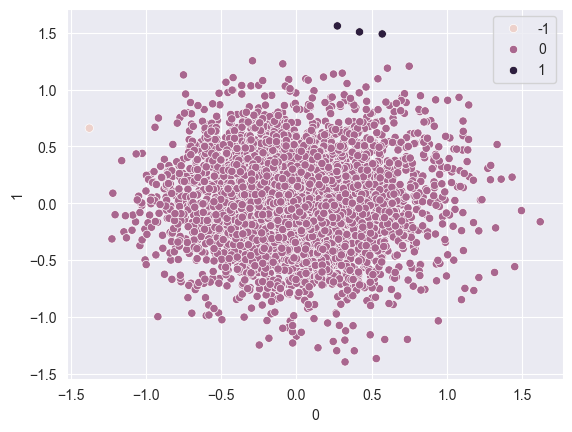

In [47]:
# YOUR CODE HERE
embeddings_df = pd.DataFrame(lyric_embeddings)
# Applying PCA to the embedding reducing the dimensionality to two
pca = PCA(n_components=2)
pca_embeddings = pd.DataFrame(pca.fit_transform(embeddings_df))
clt = DBSCAN(eps=0.3, min_samples=2)
model = clt.fit(pca_embeddings)
clustering = model.fit_predict(pca_embeddings)
sns.scatterplot(x=pca_embeddings[0],y=pca_embeddings[1], hue=clustering)

### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

_Note: You do not have to find exactly two clusters. Having at least two clusters, you should show the lyrics from two distinct clusters._ 

In [48]:
# Lyrics contained in one cluster
for i,cl in enumerate(clustering):
    if(cl == 1):
        display(swift_df.lyric[swift_df_proc.index[i]])

"Come feel this magic I've been feeling since I met you"

'Back to a first-glance feeling on New York time'

"I left a note on the door with a joke we'd made"

In [49]:
# Lyrics contained in one cluster
for i,cl in enumerate(clustering):
    if(cl == -1):
        display(swift_df.lyric[swift_df_proc.index[i]])

'Missing him was dark gray, all alone Whoa'

__Student Answer:__ The lyrics in each cluster are dissimilar. The first one is more about feeling of being delighted due to the past. And the second one is more melancholy.

## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [52]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """
    str_list = reg_tokenizer.tokenize(lyric)
    str_list = [ x.lower() for x in str_list]
    
    return str_list

### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [113]:
lyric_corpus =[]
for line in swift_df.lyric:
    lyric_corpus.append(lyric_preprocessor(line))

Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [130]:
train_2, vocab_2 = padded_everygram_pipeline(2, lyric_corpus)
train_5, vocab_5 = padded_everygram_pipeline(5, lyric_corpus)
grams_5 = MLE(5)
grams_2 = MLE(2)
grams_2.fit(train_2, vocab_2)
grams_5.fit(train_5, vocab_5)

### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

_Reminder / Hints: A lyric generated by an n-gram starts with n-1 times the start token "\<s>" and ends with n-1 times the end token "\</s>". Further, the n value of an n-gram can be accessed using the `n-gram.order` variable of an `n-gram`. Additionally keep in mind that you can condition the generation of your n-gram on some preceding text._

In [176]:


def generate_lyrics(n_gram_model, numb_of_new_lyrics: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """
    return_lyrics = []
    lyric_line = []
    order = n_gram_model.order
    start_flag = False
    end_flag = False
    start_token = ''
    end_token = ''
    start_token_count =0
    end_token_count =0
    
    for temp in range(order-1):
        start_token +='<s>'
        end_token +='</s>'
    while len(return_lyrics)< numb_of_new_lyrics:
        generate_words = n_gram_model.generate(text_seed='<s>')
        if not start_flag:
            if generate_words == '<s>':
                start_token_count+=1
                if start_token_count == order-1:
                    start_flag=True
                    start_token_count = 0
                    lyric_line.append(start_token)
            else:
                start_token_count = 0
        else:
            
            if generate_words == '</s>':
                end_token_count+=1
                if end_token_count == order-1:
                    lyric_line.append(end_token)
                    temp_str = ''
                    for temp in lyric_line:
                        temp_str += temp+" "
                    # remove last empty space
                    temp_str = temp_str[:-1]
                    return_lyrics.append(temp_str)
                    lyric_line =[]
                    start_flag = False
                    end_token_count = 0
                    
            else:
                lyric_line.append(generate_words)
                end_token_count = 0
    return return_lyrics

ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

In [177]:
# Generate and show ten lyrics with the first model
generate_lyrics(grams_2,10)

['<s> he our burning gold new di </s>',
 '<s> can darling united ask </s>',
 '<s> times tonight you all it am twenty people never and i out and too the re <s> <s> <s> us dream </s>',
 '<s> with <s> t right you the never ha i you red was to shine </s>',
 '<s> last you night know sayin and like it </s>',
 '<s> away <s> make <s> the message ma we my m say ll was </s>',
 '<s> <s> <s> like you <s> oh i oh <s> just d good could to could there love </s>',
 '<s> d fantasy strike <s> that it no died you t you </s>',
 '<s> </s>',
 '<s> get there drug </s>']

In [178]:
# Generate and show ten lyrics with the first model
generate_lyrics(grams_5,10)

['<s><s><s><s> <s> keep reasons <s> you it do <s> and he to headlights behind <s> <s> <s> meet and so phone the t abigail <s> worth <s> cornelia boy s <s> where <s> </s></s></s></s>',
 '<s><s><s><s> <s> <s> <s> in <s> <s> <s> <s> <s> <s> soon me only five both want t <s> table if <s> they i <s> this <s> t known <s> and brought <s> la car <s> <s> me be oh <s> with help <s> <s> whoa <s> <s> it james days ve it <s> body <s> s with truck <s> <s> how <s> down bell me <s> <s> highest note together <s> <s> the <s> beautiful <s> <s> know i <s> was <s> your on <s> my <s> will go <s> <s> the <s> floats <s> tree i play <s> flames <s> <s> <s> is to <s> the it <s> t wisteria <s> i i round a t wanna me feel mine <s> <s> drive of hope you <s> <s> <s> used were the grow i <s> <s> i <s> <s> this <s> if had i <s> <s> <s> <s> too room don <s> at heat deep a <s> fake bedpost be oh <s> <s> think <s> <s> <s> <s> <s> your it expect from lipstick <s> the woods <s> <s> the never <s> <s> <s> hear i way <s> <s> 

__Student Answer:__ The lyric of 5-gram is significant longer than the 2-gram.